In [84]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, ELU
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.layers.core import Lambda
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from PIL import Image
import PIL

import os
import pickle
import csv
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [85]:
#Read in the data from the csv file.
colnames = ['center', 'left', 'right', 'steering', 'throttle', 'breaking', 'speed']
data = pd.read_csv('./driving_log.csv', names=colnames, header=None)
print('The training set has %d images from the center camera.'%data['center'].shape[0])

The training set has 8037 images from the center camera.


In [86]:
data['steering'][1:] = data['steering'][1:].astype('float32')
nonZeroSamples=data.loc[data['steering']!= 0.0,:]
zeroSamples=data.loc[data['steering'] == 0.0,:]
print('The training set has %d images with zero steering and %d images with non-zero steering.'%(zeroSamples.shape[0], nonZeroSamples.shape[0]))

#As half of the dataset has steering value at zero, we reduce 80% of the zero steering samples to avoid overfitting.
fraction = 0.2
newdata = pd.concat([nonZeroSamples, zeroSamples.sample(frac=fraction)], ignore_index=True)
print('The new dataset has %d samples.'%newdata.shape[0])

#Shuffle the data
newdata.sample(frac=1)
print('The dataset has been shuffled.')

The training set has 4361 images with zero steering and 3676 images with non-zero steering.
The new dataset has 4548 samples.
The dataset has been shuffled.


In [87]:
X_center = np.array([np.array(mpimg.imread(fname)) for fname in newdata['center'][1:].values])
X_left = np.array([np.array(mpimg.imread(fname[1:])) for fname in newdata['left'][1:].values])
X_right = np.array([np.array(mpimg.imread(fname[1:])) for fname in newdata['right'][1:].values])

The dataset contains 4547 sets of images.
A typical image taken by the camera has the shape of (160, 320, 3)

 An example of center image:


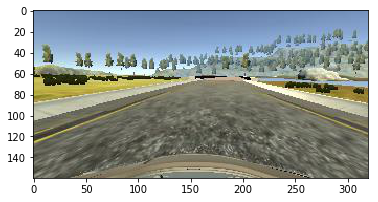

An example of left image:


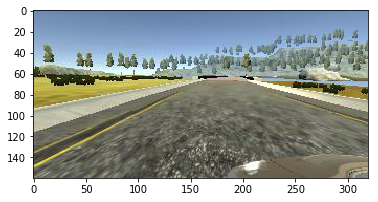

An example of right image:


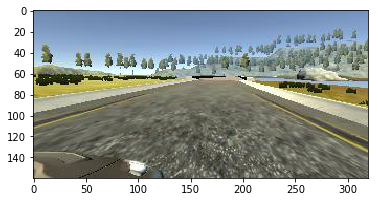

In [89]:
print ('The dataset contains %d sets of images.' %len(X_center))
print ('A typical image taken by the camera has the shape of %s' %str(X_center[0].shape))
print ('\n An example of center image:')
plt.imshow(X_center[0])
plt.show()
print ('An example of left image:')
plt.imshow(X_left[0])
plt.show()
print ('An example of right image:')
plt.imshow(X_right[0])
plt.show()

In [90]:
#pre-process the image by cutting the top 60 and bottom 25 pixels. The cropped image is then resized to 90*30 to reduce the training time.
def preprocess(img):
    img_crop=img[60:-25,:,:]
    img_resize=cv2.resize(img_crop, (90,30), cv2.INTER_AREA)
    return img_resize

In [102]:
#augment data by 1. randomly selecting left/center/right cameras 2. randomly flipping the image
def augmentdata(X_center, X_left, X_right, steering):
    X_new = np.zeros([len(X_center), 30, 90, 3], dtype=np.float32)
    y_new = np.zeros([len(X_center)], dtype=np.float32)
    
    for j in range(len(X_center)):
        #Randomly select cameras
        camera = np.random.choice(['center', 'left', 'right'])
        if camera == "left":
            steering_new = steering[j]+0.2 
            image_new=X_left[j]
        elif camera == "right":
            steering_new = steering[j]-0.2
            image_new=X_right[j]
        else:
            steering_new = steering[j]
            image_new=X_center[j]
            
        #Randomly flip
        if np.random.rand() < 0.5:
            image_new=cv2.flip(image_new,1)
            steering_new=-steering_new

        X_new[j] = preprocess(image_new)
        y_new[j] = steering_new
 
    return X_new, y_new

X_new, y_new = augmentdata(X_center, X_left, X_right, steering)



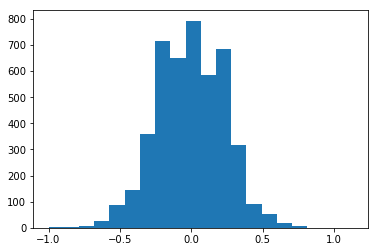

In [98]:
#the new steering set looks close to normal distribution.
plt.hist(y_new, bins=20)
plt.show()


In [100]:
#model architecture
model = Sequential()
#nomalize the data
model.add(Lambda(lambda x: x/255.-0.5,input_shape=(30,90, 3)))
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(128, 3, 3, border_mode='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(lr=1e-4), loss='mse')
model.fit(X_new, y_new, validation_split=0.2, nb_epoch=5)
model.save('./model.h5')

import json

jsonString = model.to_json() # json Model
with open('./model.json', 'w') as outFile:
    outFile.write(jsonString)


/Users/julienliu/miniconda3/envs/TrafficSign/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  '` call to the Keras 2 API: ' + signature)
/Users/julienliu/miniconda3/envs/TrafficSign/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  '` call to the Keras 2 API: ' + signature)
/Users/julienliu/miniconda3/envs/TrafficSign/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  '` call to the Keras 2 API: ' + signature)
/Users/julienliu/miniconda3/envs/TrafficSign/lib/python3.5/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3637 samples, validate on 910 samples
Epoch 1/5
3637/3637 [==============================] - 46s - loss: 0.0381 - val_loss: 0.0180

In [103]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 30, 90, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 90, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 7, 22, 64)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 22, 128)        73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 3, 11, 128)        0         
__________